<a href="https://colab.research.google.com/github/kbrezinski/JAX-Practice/blob/main/nn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP Training on MNIST

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [ ]:
# constants
seed = 0
mnist_img_size = 784

def init_MLP(layer_widths, parent_key, scale=0.01):

  params = []
  keys = jax.random.split(parent_key, num=len(layer_widths) - 1)

  for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):

    weight_key, bias_key = jax.random.split(key)
    params.append(
        [scale * jax.random.normal(weight_key, shape=(out_width, in_width)), # weights = (hidden dims, input)
         scale * jax.random.normal(bias_key, shape=(out_width,))]           # biases = (hidden_dims, 1)
    )
  return params

parent_key = jax.jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], parent_key)
jax.tree_map(lambda x: x.shape, MLP_params)

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]

In [ ]:
def predict_MLP(params, x):

  hidden_layers = params[:-1]

  activation = x
  for w, b in hidden_layers:
    # ReLu( dot((512, 784)(784, 1)))
    activation = jax.nn.relu(jnp.dot(w, activation) + b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation) + b_last

  # mimics the same behavior as the softmax
  return logits - logsumexp(logits) # log(exp(o1)) - log(sum(exp(01), exp(02), ..., exp(03)))


# Create single fake image
dummy_img_flat = np.random.randn(mnist_img_size)
prediction = predict_MLP(MLP_params, dummy_img_flat)
assert dummy_img_flat.shape == (784,)

# Create batch of fake images
dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
assert dummy_imgs_flat.shape == (16, 784)

# Test batched function on batched MP predict, where 0 axis is the batch dim
batched_MLP_predict = vmap(predict_MLP, in_axes=(None, 0))
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(16, 10)


In [ ]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(128, 784) float32 (128,) int64


In [ ]:
def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)
    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_labels, lr=0.01):
  loss, grad = value_and_grad(loss_fn)(params, imgs, gt_labels)
  return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grad)

MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], parent_key)

## training loop
for epoch in range(5):
  for i, (imgs, labels) in enumerate(train_loader):

    one_hot_labels = jax.nn.one_hot(labels, len(MNIST.classes))
    loss, MLP_params = update(MLP_params, imgs, one_hot_labels)

    if i % 50 == 0:
      print(loss)

  print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, imgs, labels)}') 

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


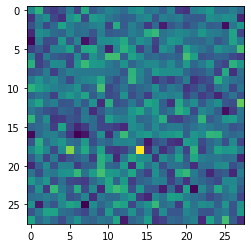

In [ ]:
## visualize the weights
import matplotlib.pyplot as plt

w = MLP_params[0][0]
print(jax.tree_map(lambda x: x.shape, MLP_params))
w_single = w[501, :].reshape(28, 28)  # look at the 500th embedding
plt.imshow(w_single)

In [ ]:
from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

# fetch the activations of 
batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))  # (128, 784)

# fetch activation up until the final layer
batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 256) after t-SNE will be (128, 2)

(128, 256)
